Gate Cutting to Reduce Circuit Width

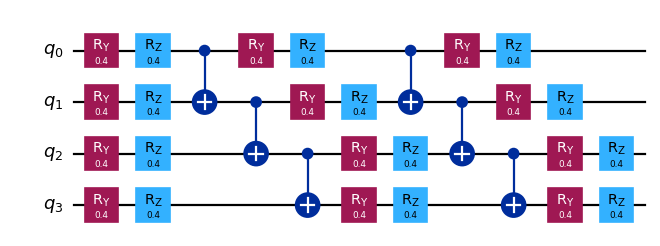

In [27]:
from qiskit.circuit.library import efficient_su2

qc = efficient_su2(4, entanglement="linear", reps=2)
qc.assign_parameters([0.4] * len(qc.parameters), inplace=True)

qc.draw("mpl", scale=0.8)

In [28]:
from qiskit.quantum_info import SparsePauliOp

observable = SparsePauliOp(["ZZII", "IZZI", "-IIZZ", "XIXI", "ZIZZ", "IXIX"])

In [29]:
from qiskit_addon_cutting import partition_problem

partitioned_problem = partition_problem(
    circuit=qc, partition_labels="AABB", observables=observable.paulis
)
subcircuits = partitioned_problem.subcircuits
subobservables = partitioned_problem.subobservables
bases = partitioned_problem.bases

In [30]:
subobservables

{'A': PauliList(['II', 'ZI', 'ZZ', 'XI', 'ZZ', 'IX']),
 'B': PauliList(['ZZ', 'IZ', 'II', 'XI', 'ZI', 'IX'])}

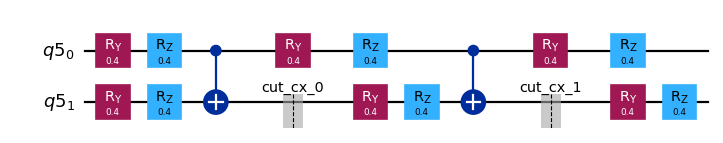

In [31]:
subcircuits["A"].draw("mpl", scale=0.8)

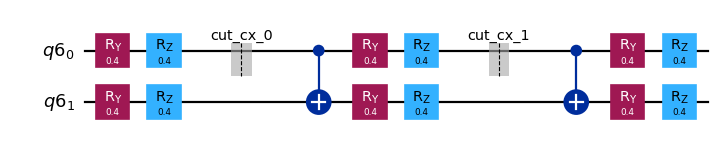

In [32]:
subcircuits["B"].draw("mpl", scale=0.8)

In [33]:
import numpy as np

print(f"Sampling overhead: {np.prod([basis.overhead for basis in bases])}")

Sampling overhead: 81.0


In [34]:
from qiskit_addon_cutting import generate_cutting_experiments

subexperiments, coefficients = generate_cutting_experiments(
    circuits=subcircuits, observables=subobservables, num_samples=np.inf
)

In [35]:
from qiskit_ibm_runtime.fake_provider import FakeManilaV2

backend = FakeManilaV2()

In [36]:
from qiskit.transpiler import generate_preset_pass_manager

# Transpile the subexperiments to ISA circuits
pass_manager = generate_preset_pass_manager(optimization_level=1, backend=backend)
isa_subexperiments = {
    label: pass_manager.run(partition_subexpts)
    for label, partition_subexpts in subexperiments.items()
}

In [37]:
from qiskit_ibm_runtime import SamplerV2, Batch

# Submit each partition's subexperiments to the Qiskit Runtime Sampler
# primitive, in a single batch so that the jobs will run back-to-back.
with Batch(backend=backend) as batch:
    sampler = SamplerV2(mode=batch)
    jobs = {
        label: sampler.run(subsystem_subexpts, shots=2**12)
        for label, subsystem_subexpts in isa_subexperiments.items()
    }

In [38]:
# Retrieve results
results = {label: job.result() for label, job in jobs.items()}

In [39]:
from qiskit_addon_cutting import reconstruct_expectation_values

# Get expectation values for each observable term
reconstructed_expval_terms = reconstruct_expectation_values(
    results,
    coefficients,
    subobservables,
)

# Reconstruct final expectation value
reconstructed_expval = np.dot(reconstructed_expval_terms, observable.coeffs)

In [40]:
from qiskit_aer.primitives import EstimatorV2

estimator = EstimatorV2()
exact_expval = estimator.run([(qc, observable)]).result()[0].data.evs
print(f"Reconstructed expectation value: {np.real(np.round(reconstructed_expval, 8))}")
print(f"Exact expectation value: {np.round(exact_expval, 8)}")
print(f"Error in estimation: {np.real(np.round(reconstructed_expval-exact_expval, 8))}")
print(
    f"Relative error in estimation: {np.real(np.round((reconstructed_expval-exact_expval) / exact_expval, 8))}"
)

Reconstructed expectation value: 0.49947906
Exact expectation value: 0.56254612
Error in estimation: -0.06306707
Relative error in estimation: -0.11211004
